In [17]:
import os, re
import argparse

# import nest_asyncio
import numpy as np
import pandas as pd
import lightkurve as lk
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io import fits
from tqdm import tqdm
from astrocut import CutoutFactory
from ipywidgets import *
import matplotlib.colors as colors
from matplotlib import patches
from astropy.stats import sigma_clip
from glob import glob

from tess_asteroid_ml import *
from tess_asteroid_ml.make_TESS_asteroid_db import *
from tess_asteroid_ml.utils import in_cutout, power_find

import pickle
import warnings
warnings.simplefilter('ignore')

In [8]:
from tess_asteroid_ml.make_TESScut_asteroids import *

In [9]:
os.path.dirname(PACKAGEDIR)

'/Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml'

In [10]:
def fit_bkg(tpf:lk.TessTargetPixelFile, polyorder:int=1) -> np.ndarray:
    """Fit a simple 2d polynomial background to a TPF
    
    Parameters
    ----------
    tpf: lightkurve.TessTargetPixelFile
        Target pixel file object
    polyorder: int
        Polynomial order for the model fit.
        
    Returns
    -------
    model : np.ndarray
        Model for background with same shape as tpf.shape
    """
    
    if not isinstance(tpf, lk.TessTargetPixelFile):
        raise ValueError("Input a TESS Target Pixel File")
    
    if (np.product(tpf.shape[1:]) < 100) | np.any(np.asarray(tpf.shape[1:]) < 6):
        raise ValueError("TPF too small. Use a bigger cut out.")
        
        
    # Grid for calculating polynomial
    R, C = np.mgrid[:tpf.shape[1], :tpf.shape[2]].astype(float)
    R -= tpf.shape[1]/2
    C -= tpf.shape[2]/2
    
    
    def func(tpf):
        # Design matrix
        A = np.vstack([R.ravel()**idx*C.ravel()**jdx for idx in range(polyorder + 1) for jdx in range(polyorder + 1)]).T
        
        # Median star image
        m = np.median(tpf.flux.value, axis=0)
        # Remove background from median star image
        mask = ~sigma_clip(m, sigma=3).mask.ravel()
        #plt.imshow(mask.reshape(m.shape))
        bkg0 = A.dot(np.linalg.solve(A[mask].T.dot(A[mask]), A[mask].T.dot(m.ravel()[mask]))).reshape(m.shape)
        
        m -= bkg0

        # Include in design matrix
        A = np.hstack([A, m.ravel()[:, None]])
        
        # Fit model to data, including a model for the stars
        f = np.vstack(tpf.flux.value.transpose([1, 2, 0]))
        ws = np.linalg.solve(A.T.dot(A), A.T.dot(f))
        
        # Build a model that is just the polynomial
        model = (A[:, :-1].dot(ws[:-1])).reshape((tpf.shape[1], tpf.shape[2], tpf.shape[0])).transpose([2, 0, 1])
        # model += bkg0
        return model
    
    # Break point for TESS orbit
    b = np.where(np.diff(tpf.cadenceno) == np.diff(tpf.cadenceno).max())[0][0] + 1
    
    # Calculate the model for each orbit, then join them
    model = np.vstack([func(tpf) for tpf in [tpf[:b], tpf[b:]]])
    return model

In [11]:
np.random.seed(0)
sectors = [4, 5, 6]
cameras = [1, 2, 3, 4]
ccds = [1, 2, 3, 4]
fit_bkg = True

grid = []
for s in sectors:
    for cam in cameras:
        for cc in ccds:
            grid.append([s, cam, cc])
selected = np.random.randint(0, len(grid), size=10)
selected = np.array(grid)[selected]
selected = selected[np.argsort(selected[:, 0])]
selected

array([[4, 1, 1],
       [4, 1, 4],
       [4, 1, 4],
       [4, 3, 2],
       [5, 1, 4],
       [5, 2, 2],
       [6, 4, 1],
       [6, 4, 4],
       [6, 2, 4],
       [6, 2, 1]])

In [12]:
selected = np.array(
   [[4, 1, 1],
    [4, 1, 4],
    [4, 2, 3],
    [4, 3, 2],
    [5, 1, 4],
    [5, 2, 2],
    [6, 3, 1],
    [6, 4, 4],
    [6, 2, 4],
    [6, 1, 1]]
)

['https://archive.stsci.edu/missions/tess/ffi/s0004/2018/307/1-1/tess2018307065939-s0004-1-1-0124-s_ffic.fits']
Loading from CSV file: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/jpl/jpl_small_bodies_tess_s0004-1-0_catalog.csv
JPL SBI found 25424 asteroids with V < 30 in s0004-1-0
                             Object name Astrometric RA (hh:mm:ss)  \
0                    23 Thalia (A852 XA)               02:17:25.72   
1                    46 Hestia (A857 QA)               02:06:33.37   
2                     307 Nike (A891 EB)               01:53:36.72   
3                318 Magdalena (A891 SA)               01:49:45.16   
4                   381 Myrrha (A894 AC)               03:26:13.42   
...                                  ...                       ...   
25414    P/2004 DO29 (Spacewatch-LINEAR)               03:09:38.94   
25417  P/2011 JB15 (Spacewatch-Boattini)               03:40:16.38   
25418               C/2012 Q1 (Kowalski)               02:44:24.73   
25419 

16818


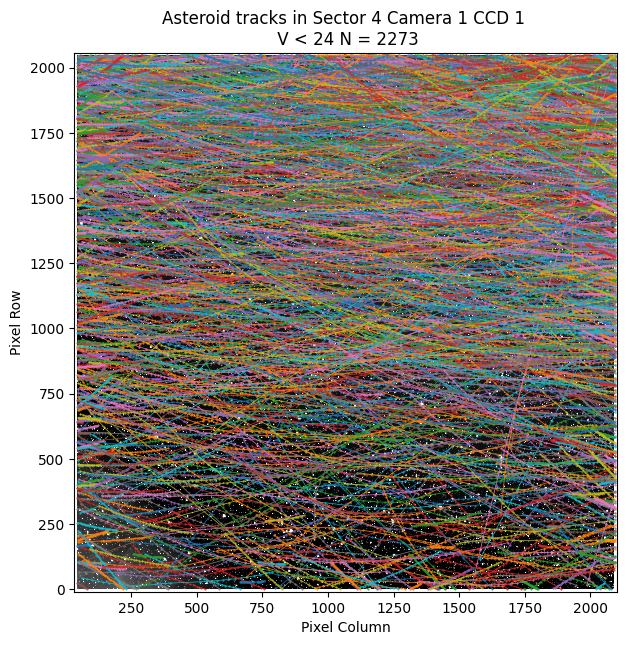

[[  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 ...
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]] [[  34   34   34 ...   34   34   34]
 [  93   93   93 ...   93   93   93]
 [ 152  152  152 ...  152  152  152]
 ...
 [1863 1863 1863 ... 1863 1863 1863]
 [1922 1922 1922 ... 1922 1922 1922]
 [1981 1981 1981 ... 1981 1981 1981]] (34, 34)
Working with row 15/33 and 33 cuts...


TESS cut files row 15: 100%|██████████████████████████████████████████████████████████| 33/33 [03:30<00:00,  6.39s/it]


Working with row 19/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0137_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0196_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0255_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0314_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0373_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0432_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0491_r1155_64x64pix.f

TESS cut files row 19: 100%|██████████████████████████████████████████████████████████| 33/33 [03:03<00:00,  5.57s/it]


Working with row 25/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0137_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0196_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0255_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0314_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0373_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0432_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-1_c0491_r1509_64x64pix.f

TESS cut files row 25: 100%|██████████████████████████████████████████████████████████| 33/33 [03:31<00:00,  6.41s/it]


['https://archive.stsci.edu/missions/tess/ffi/s0004/2018/307/1-4/tess2018307065939-s0004-1-4-0124-s_ffic.fits']
Loading from CSV file: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/jpl/jpl_small_bodies_tess_s0004-1-0_catalog.csv
JPL SBI found 25424 asteroids with V < 30 in s0004-1-0
                             Object name Astrometric RA (hh:mm:ss)  \
0                    23 Thalia (A852 XA)               02:17:25.72   
1                    46 Hestia (A857 QA)               02:06:33.37   
2                     307 Nike (A891 EB)               01:53:36.72   
3                318 Magdalena (A891 SA)               01:49:45.16   
4                   381 Myrrha (A894 AC)               03:26:13.42   
...                                  ...                       ...   
25414    P/2004 DO29 (Spacewatch-LINEAR)               03:09:38.94   
25417  P/2011 JB15 (Spacewatch-Boattini)               03:40:16.38   
25418               C/2012 Q1 (Kowalski)               02:44:24.73   
25419 

16818


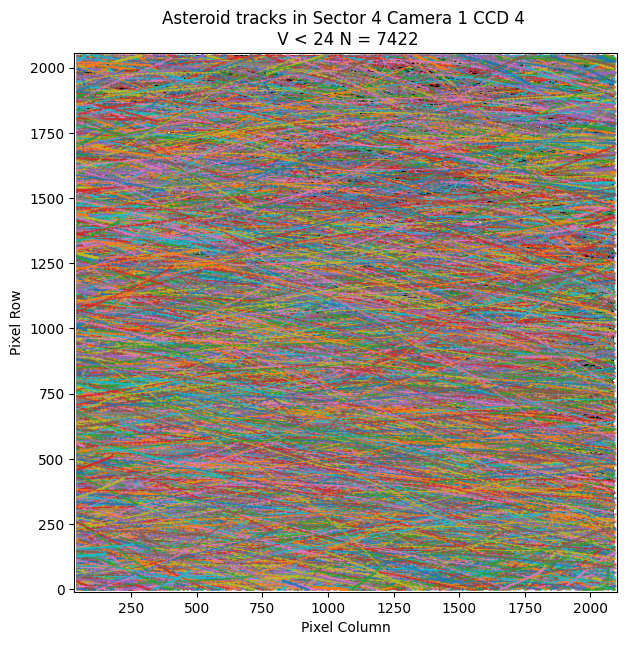

[[  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 ...
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]] [[  34   34   34 ...   34   34   34]
 [  93   93   93 ...   93   93   93]
 [ 152  152  152 ...  152  152  152]
 ...
 [1863 1863 1863 ... 1863 1863 1863]
 [1922 1922 1922 ... 1922 1922 1922]
 [1981 1981 1981 ... 1981 1981 1981]] (34, 34)
Working with row 15/33 and 33 cuts...


TESS cut files row 15: 100%|██████████████████████████████████████████████████████████| 33/33 [10:02<00:00, 18.27s/it]


Working with row 19/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0137_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0196_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0255_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0314_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0373_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0432_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0491_r1155_64x64pix.f

TESS cut files row 19: 100%|██████████████████████████████████████████████████████████| 33/33 [09:05<00:00, 16.52s/it]


Working with row 25/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0137_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0196_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0255_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0314_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0373_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0432_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-1-4_c0491_r1509_64x64pix.f

TESS cut files row 25: 100%|██████████████████████████████████████████████████████████| 33/33 [07:33<00:00, 13.76s/it]


['https://archive.stsci.edu/missions/tess/ffi/s0004/2018/307/2-3/tess2018307065939-s0004-2-3-0124-s_ffic.fits']
Loading from CSV file: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/jpl/jpl_small_bodies_tess_s0004-2-0_catalog.csv
JPL SBI found 2226 asteroids with V < 30 in s0004-2-0
                    Object name Astrometric RA (hh:mm:ss)  \
0        863 Benkoela (A917 CG)               03:54:10.28   
1          1025 Riema (A923 PG)               03:08:40.14   
2           2291 Kevo (1941 FS)               03:04:50.74   
3     3101 Goldberger (1978 GB)               04:08:33.69   
4          3169 Ostro (1981 LA)               03:58:17.26   
...                         ...                       ...   
2219       C/2012 Q1 (Kowalski)               02:44:24.75   
2220         C/2012 X1 (LINEAR)               02:53:48.41   
2221       C/2013 G7 (McNaught)               04:27:01.17   
2223         C/2017 S7 (Lemmon)               04:20:19.81   
2225      C/2021 S3 (PANSTARRS)     

1893


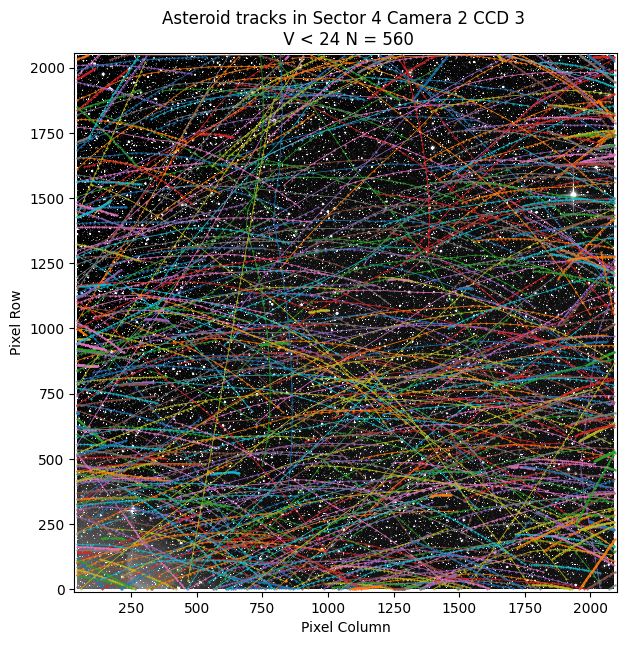

[[  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 ...
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]] [[  34   34   34 ...   34   34   34]
 [  93   93   93 ...   93   93   93]
 [ 152  152  152 ...  152  152  152]
 ...
 [1863 1863 1863 ... 1863 1863 1863]
 [1922 1922 1922 ... 1922 1922 1922]
 [1981 1981 1981 ... 1981 1981 1981]] (34, 34)
Working with row 15/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0137_r0919_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0196_r0919_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0255_r0919_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/

TESS cut files row 15: 100%|██████████████████████████████████████████████████████████| 33/33 [02:15<00:00,  4.10s/it]


Working with row 19/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0137_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0196_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0255_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0314_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0373_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0432_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0491_r1155_64x64pix.f

TESS cut files row 19: 100%|██████████████████████████████████████████████████████████| 33/33 [02:41<00:00,  4.89s/it]


Working with row 25/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0137_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0196_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0255_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0314_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0373_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0432_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-2-3_c0491_r1509_64x64pix.f

TESS cut files row 25: 100%|██████████████████████████████████████████████████████████| 33/33 [02:22<00:00,  4.33s/it]


['https://archive.stsci.edu/missions/tess/ffi/s0004/2018/307/3-2/tess2018307065939-s0004-3-2-0124-s_ffic.fits']
Loading from CSV file: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/jpl/jpl_small_bodies_tess_s0004-3-0_catalog.csv
JPL SBI found 330 asteroids with V < 30 in s0004-3-0
            Object name Astrometric RA (hh:mm:ss) Astrometric Dec (dd mm'ss")  \
0      16005 (1999 BP7)               02:07:13.10                 -32:06:20.4   
1       17590 (1995 CG)               02:28:22.36                 -31:59:35.9   
2       20996 (1986 PB)               02:51:53.43                 -33:04:14.1   
3      30968 (1995 AM1)               02:26:57.44                 -35:31:41.3   
4     36343 (2000 NZ15)               02:21:41.79                 -33:50:41.0   
..                  ...                       ...                         ...   
312          (2022 XX1)               02:00:41.57                 -44:38:18.2   
316          (2023 LQ5)               02:32:24.04           

194


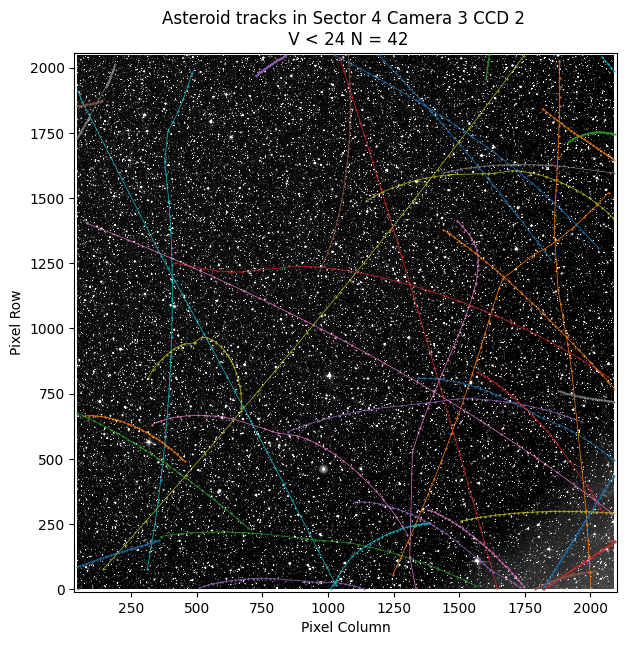

[[  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 ...
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]
 [  34   93  152 ... 1863 1922 1981]] [[  34   34   34 ...   34   34   34]
 [  93   93   93 ...   93   93   93]
 [ 152  152  152 ...  152  152  152]
 ...
 [1863 1863 1863 ... 1863 1863 1863]
 [1922 1922 1922 ... 1922 1922 1922]
 [1981 1981 1981 ... 1981 1981 1981]] (34, 34)
Working with row 15/33 and 33 cuts...


TESS cut files row 15: 100%|██████████████████████████████████████████████████████████| 33/33 [02:15<00:00,  4.12s/it]


Working with row 19/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0137_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0196_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0255_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0314_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0373_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0432_r1155_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0491_r1155_64x64pix.f

TESS cut files row 19: 100%|██████████████████████████████████████████████████████████| 33/33 [02:22<00:00,  4.33s/it]


Working with row 25/33 and 33 cuts...
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0137_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0196_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0255_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0314_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0373_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0432_r1509_64x64pix.fits
Creating FFI cut: /Users/jorgemarpa/Work/BAERI/ADAP/tess-asteroid-ml/data/tesscuts/sector0004/TESScut_s0004-3-2_c0491_r1509_64x64pix.f

TESS cut files row 25: 100%|██████████████████████████████████████████████████████████| 33/33 [01:58<00:00,  3.60s/it]


In [9]:
for k in range(0, 4):
    sector, camera, ccd = selected[k]
    provider = "mast"
    maglim = 24
    
    ffi_file = get_FFI_name(sector=sector, camera=camera, ccd=ccd, provider=provider, correct=False)
    print(ffi_file)
    
    # get FFI data to build ra/dec coordinates for later query
    
    ffi_header, f2d, col_2d, row_2d, ra_2d, dec_2d = get_data_from_files(
        ffi_file, provider=provider
    )
    ffi_header = ffi_header[0]
    f2d = f2d[0]
    col_2d = col_2d
    row_2d = row_2d
    ra_2d = ra_2d[0]
    dec_2d = dec_2d[0]
    
    obs_time = Time([ffi_header["DATE-OBS"], ffi_header["DATE-END"]], format="isot")
    
    jpl_df = get_asteroid_table(
        SkyCoord(ra_2d.min() * u.deg, dec_2d.min() * u.deg, frame='icrs'),
        SkyCoord(ra_2d.max() * u.deg, dec_2d.max() * u.deg, frame='icrs'),
        sector=sector,
        camera=camera,
        ccd=0,
        date_obs=obs_time.mean().jd,
    )
    if maglim <= 30:
        asteroid_df = jpl_df.query(f"V_mag <= {maglim}")
    print(asteroid_df)
    
    sb_ephems_lowres = read_asteroid_db(
        asteroid_df, low_res=True, sector=sector, camera=camera, ccd=ccd
    )
    print(len(sb_ephems_lowres))
    
    vlo, lo, mid, hi, vhi = np.nanpercentile(f2d, [0.2, 3, 50, 95, 99])
    cnorm = colors.LogNorm(vmin=lo, vmax=vhi)
    
    plt.figure(figsize=(7,7))
    plt.pcolormesh(col_2d, row_2d, f2d, norm=cnorm, cmap="Greys_r")
    
    counter = 0
    for k, val in sb_ephems_lowres.items():
        if len(val) == 0:
            continue
        val = val.query(f"camera == {camera} and ccd == {ccd}")
        if len(val) > 0: counter += 1
        plt.plot(val.column, val.row, ".-", ms=1., lw=.5)
        # if k == 1: break
    plt.title(f"Asteroid tracks in Sector {sector} Camera {camera} CCD {ccd} \n "
              f"V < {maglim} N = {counter}")
    
    plt.xlim(col_2d.min() - 10, col_2d.max() + 10)
    plt.ylim(row_2d.min() - 10, row_2d.max() + 10)
    # plt.gca().set_aspect('equal')
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    cutout_size = 64
    xcen, ycen = get_cutout_centers(sampling="tiled", overlap=5, size=cutout_size)
    print(xcen, ycen, xcen.shape)
    
    sb_ephems_highres = {}
    
    download = True
    fficuts_list = []
    
    for nrow, i in enumerate(ycen[1:, 0]):
        # if np.random.choice([1,1,1]):
        #     continue
        # if nrow + 1 not in [3, 5, 8, 11, 15, 19, 25]:
        if nrow + 1 not in [15, 19, 25]:
            continue
            
        if True:
            sb_ephems_highres = {}
        
        F, X, Y, L, NAMES = [], [], [], [], []
        cut_dict = {}
        for j in xcen[0, 1:]:
            # if not (j < 200 or j > 1800):
            #     continue
            cut_dict[f"c{col_2d[i, j]:04}_r{row_2d[i,j]:04}"] = SkyCoord(
                ra_2d[i, j] * u.deg, dec_2d[i, j] * u.deg, frame="icrs"
            )
            # if j > 1000: break
        
        print(f"Working with row {nrow + 1}/{len(ycen[1:, 0])} and {len(cut_dict)} cuts...")
    
        if download:
            tpf_names = get_cutouts(
                    cut_dict,
                    sector=sector,
                    cam_ccd=f"{camera}-{ccd}",
                    cutout_size=cutout_size,
                )
        else:
            tpf_names = glob(f"{os.path.dirname(PACKAGEDIR)}/data/tesscuts/sector{sector:04}"
                             f"/TESScut_s{sector:04}-{camera}-{ccd}_c*_r*_{cutout_size}x{cutout_size}pix.fits")
            tpf_names = np.random.choice(tpf_names, size=100, replace=False)
    
        for q, ff in tqdm(enumerate(tpf_names), 
                          total=len(tpf_names), 
                          desc=f"TESS cut files row {nrow + 1}", ):
    
            fficut_aster = AsteroidTESScut(lk.read(ff, quality_bitmask=None))
            fficut_aster.ffi_exp_time = (ffi_header["TSTOP"] - ffi_header["TSTART"]) * 24 * 3600
            fficut_aster.get_CBVs(align=False, interpolate=True)
            fficut_aster.get_quaternions_and_angles()
            if fit_bkg:
                # print("median: ",np.median(fficut_aster.flux), "min: ", fficut_aster.flux.min())
                fficut_aster.fit_background(polyorder=3, positive_flux=True)
                # print("median: ",np.median(fficut_aster.flux), "min: ", fficut_aster.flux.min())
    
            for k, val in sb_ephems_lowres.items():
                if len(val) == 0:
                    continue
                # check if asteroid track passes over the TESScut
                is_in = in_cutout(
                    fficut_aster.column,
                    fficut_aster.row,
                    sb_ephems_lowres[k].column.values,
                    sb_ephems_lowres[k].row.values,
                )
                if is_in:
                    # print(
                    #     f"({k}) Asteroid in cutout: ", asteroid_df.loc[k, "name"]
                    # )
                    # load full res track
                    if k not in sb_ephems_highres.keys():
                        sb_ephems_highres.update(read_asteroid_db(
                            asteroid_df.loc[[k]],
                            low_res=False,
                            sector=sector,
                            camera=camera,
                            ccd=ccd,
                            quiet=True,
                        ))
                    source_rad = 3.2e2 / (sb_ephems_highres[k].vmag.mean()) ** 1.8
                    fficut_aster.get_asteroid_mask(
                        sb_ephems_highres[k],
                        name=asteroid_df.loc[k, ["Object name", "V_mag"]],
                        mask_type="circular",
                        mask_radius=source_rad,
                        mask_num_type="dec",
                    )
            F.append(fficut_aster.flux_2d)
            X.append(fficut_aster.column_2d[0, 0])
            Y.append(fficut_aster.row_2d[0, 0])
            L.append(fficut_aster.asteroid_mask_2d)
            if hasattr(fficut_aster, "asteroid_names"):
                NAMES.append(pd.DataFrame.from_dict(fficut_aster.asteroid_names, orient="index"))
            else:
                NAMES.append(pd.DataFrame([]))
            
            if fficut_aster.asteroid_mask_2d is None:
                break
            
            if np.random.choice([0, 0 ,1]):
                fficuts_list.append(fficut_aster)
    
        fficut_aster.find_orbit_breaks()
        F, X, Y, L = np.array(F), np.array(X), np.array(Y), np.array(L)
        # if not np.isfinite(fficut_aster.quaternions).all():
        quat_nonnan_mask = np.isfinite(fficut_aster.quaternions[:, 0])
        F = F[:, quat_nonnan_mask]
        L = L[:, quat_nonnan_mask]
        TIME = fficut_aster.time[quat_nonnan_mask]
        CBV = fficut_aster.cbvs[quat_nonnan_mask]
        QUAT = fficut_aster.quaternions[quat_nonnan_mask]
        E_ANG = fficut_aster.earth_angle[quat_nonnan_mask]
        M_ANG = fficut_aster.moon_angle[quat_nonnan_mask]
            
        dts = np.diff(TIME)
        breaks = np.where(dts >= 0.2)[0] + 1
            
        if len(breaks) > 0:
            F = np.array_split(F, breaks, axis=1)
            L = np.array_split(L, breaks, axis=1)
            TIME = np.array_split(TIME, breaks, axis=0)
            CBV = np.array_split(CBV, breaks, axis=0)
            QUAT = np.array_split(QUAT, breaks, axis=0)
            E_ANG = np.array_split(E_ANG, breaks, axis=0)
            M_ANG = np.array_split(M_ANG, breaks, axis=0)
        else:
            F = [F]
            L = [L]
            TIME = [fficut_aster.time]
            CBV = [fficut_aster.cbvs]
            QUAT = [fficut_aster.quaternions]
            E_ANG = [fficut_aster.earth_angle]
            M_ANG = [fficut_aster.moon_angle]
    
        out_path = f"{os.path.dirname(PACKAGEDIR)}/data/asteroidcuts/sector{sector:04}"
        if not os.path.isdir(out_path):
            os.makedirs(out_path)
    
        out_file = (f"{out_path}/tess-asteroid-cuts_{cutout_size}x{cutout_size}"
                        f"_s{sector:04}-{camera}-{ccd}_V{maglim}_{nrow:02}.pkl")
        with open(out_file, "wb") as outp:
            pickle.dump(NAMES, outp, -1)
    
        for bk in range(len(F)):
            if len(TIME[bk]) < cutout_size + 2:
                continue
            out_file = (f"{out_path}/tess-asteroid-cuts_{cutout_size}x{cutout_size}"
                        f"_s{sector:04}-{camera}-{ccd}_V{maglim}_orb{bk+1}_bkg{str(fit_bkg)[0]}_{nrow:02}.npz")
            np.savez(out_file, 
                     flux=F[bk],
                     column=X, 
                     row=Y, 
                     mask=L[bk].astype(np.int16), 
                     time=TIME[bk], 
                     cbv=CBV[bk],
                     quat=QUAT[bk],
                     earth_angles=E_ANG[bk],
                     moon_angles=M_ANG[bk],
                    )

In [10]:
[x.shape for x in TIME]

[(337,), (106,), (579,)]

In [ ]:
[np.diff(x).max() for x in TIME]

In [ ]:
[(x.asteroid_mask_2d != 0).sum()/(x.npixels * x.ntimes)*100 for x in fficuts_list]

In [16]:
[len(x.asteroid_names) for x in fficuts_list if hasattr(x, "asteroid_names")]

[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1, 1, 1]

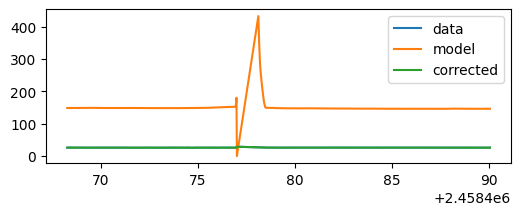

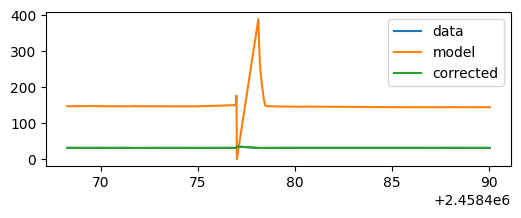

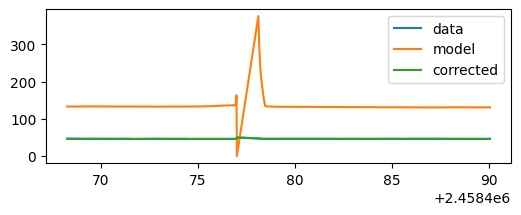

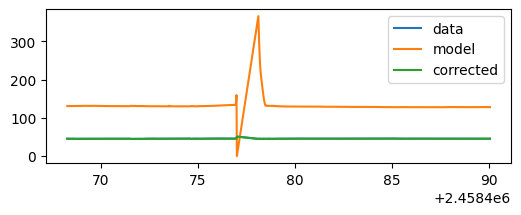

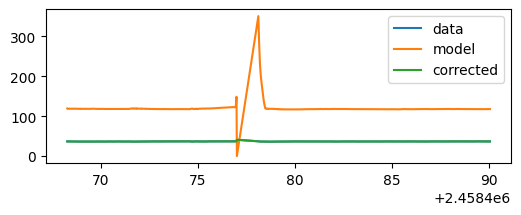

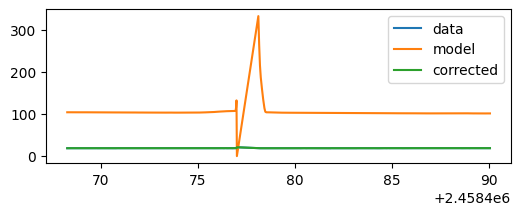

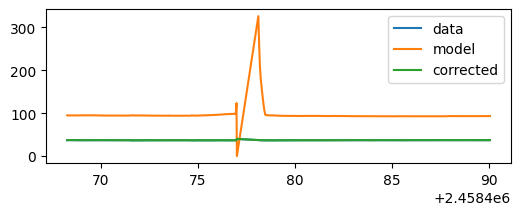

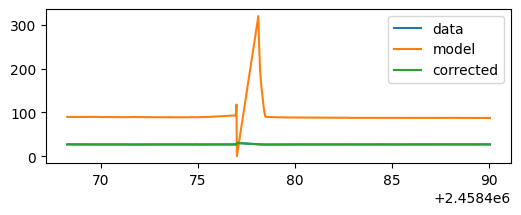

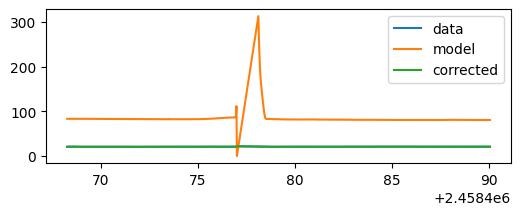

In [123]:
for obj in fficuts_list:
    plt.figure(figsize=(6,2))
    plt.plot(obj.time, np.median(obj.flux, axis=1), label="data")
    plt.plot(obj.time, np.median(np.median(obj.bkg_model, axis=1), axis=1), label="model")
    plt.plot(obj.time, np.median(obj.flux, axis=1), label="corrected")
    plt.legend()
    plt.show()

In [104]:
fficut_aster = fficuts_list[1]

In [105]:
fficut_aster.asteroid_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [106]:
time_idx = np.unique(np.hstack([x for x in fficut_aster.asteroid_time_idx.values()]))
time_idx

array([261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286,
       287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299,
       300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358])

In [107]:
fficut_aster.shape

'N times, N pixels: (981, 4096)'

In [108]:
fit_bkg(fficut_aster.tpf, polyorder=3).shape

(981, 64, 64)

In [109]:
bkg_model = fit_bkg(fficut_aster.tpf, polyorder=3)
img_frame = (fficut_aster.flux_2d - bkg_model) 
img_frame += np.abs(np.floor(np.min(img_frame)))

In [110]:
np.median(img_frame), np.mean(img_frame), img_frame.min()

(13.16857446267074, 53.156600610386675, 0.05165805553849623)

In [111]:
fficut_aster.fit_background(polyorder=3, positive_flux=True)

In [112]:
np.median(fficut_aster.flux), np.mean(fficut_aster.flux), fficut_aster.flux.min()

(13.168574, 53.1566, 0.051657677)

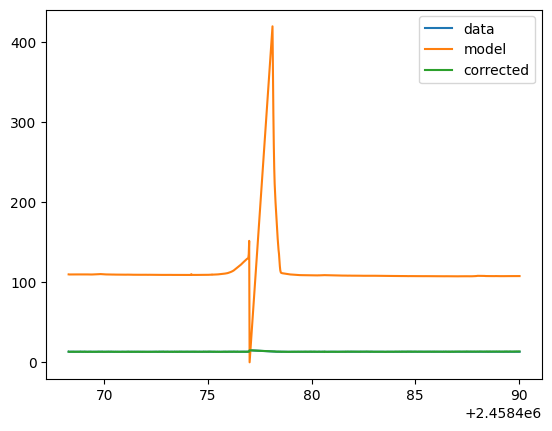

In [113]:
plt.plot(fficut_aster.time, np.median(fficut_aster.flux, axis=1), label="data")
plt.plot(fficut_aster.time, np.median(np.median(bkg_model, axis=1), axis=1), label="model")
plt.plot(fficut_aster.time, np.median(np.median(img_frame, axis=1), axis=1), label="corrected")
plt.legend()
plt.show()

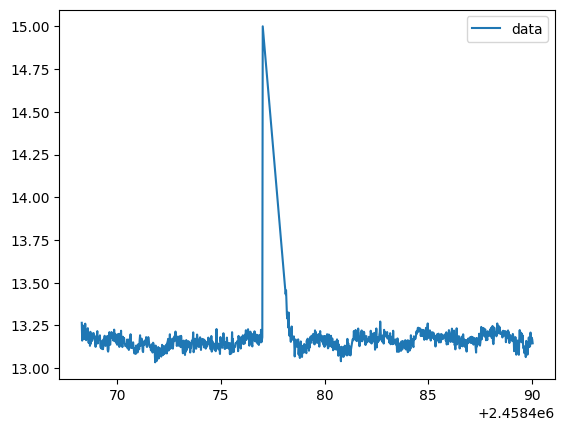

In [118]:
plt.plot(fficut_aster.time, np.median(fficuts_list[1].flux, axis=1), label="data")
# plt.plot(fficut_aster.time, np.median(np.median(fficut_aster.bkg_model, axis=1), axis=1), label="model")
# plt.plot(fficut_aster.time, np.median(fficut_aster.flux, axis=1), label="corrected")
plt.legend()
plt.show()

In [24]:
pers = [1, 70, 97, 99.8]
np.nanpercentile(img_frame, pers)

array([  1.73353328,  12.93834698, 113.36170106, 840.68378038])